### Imports

In [1]:
import cv2
import time

import numpy as np
import matplotlib.pyplot as plt

### Constants

In [2]:
SCLERA_TO_LIMBUS_RATIO = 1.7
PLANAR_SCLERA_TO_LIMBUS_RATIO = 1.25

### Helper functions

In [3]:
def detect_circle(gray, return_all=False):
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=10,
        param1=100, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=round(gray.shape[0]//1.5)
    )
    
    if circles is None:
        return None
    
    if return_all:
        return circles[0,:,:]

    return circles[0,0,:2], circles[0,0,2]

In [4]:
def linear_polar_warp(img, center, max_radius, min_radius=-1, flags=cv2.INTER_LINEAR):
    linear_polar = cv2.warpPolar(img, (0, 0), tuple(center), max_radius, cv2.WARP_POLAR_LINEAR+cv2.WARP_FILL_OUTLIERS)
    linear_polar = cv2.rotate(linear_polar, cv2.ROTATE_90_CLOCKWISE)
    linear_polar = cv2.resize(linear_polar, (0, 0), fx=2.0, fy=1.0)
    
    if min_radius > 0:
        linear_polar = linear_polar[round(min_radius):,:]
    
    return linear_polar

### Basic visualizations

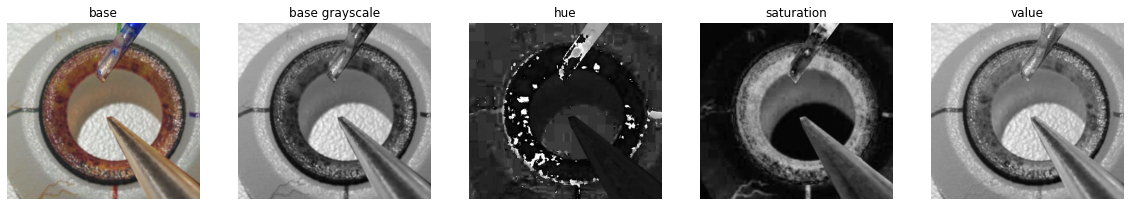

In [5]:
base = cv2.imread('data/artificial/with_markers5.jpeg', cv2.IMREAD_COLOR)
# base = cv2.imread('/home/miroslav/Downloads/test.png', cv2.IMREAD_COLOR)
base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:,:,0]
base_saturation = base_hsv[:,:,1]
base_value = base_hsv[:,:,2]

fig, (plot1, plot2, plot3, plot4, plot5) = plt.subplots(1, 5, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

In [6]:
scale = 0.4
base_gray_small = cv2.resize(base_gray, (0,0), fx=scale, fy=scale)
base_gray_small.shape

(158, 173)

### Limbus detection

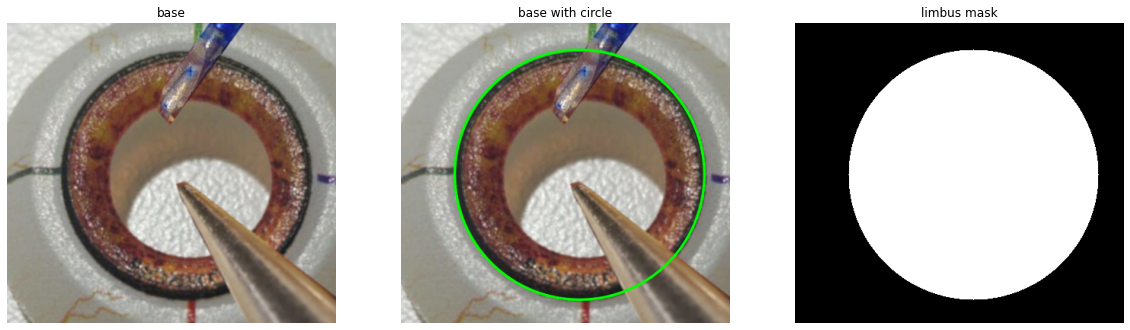

In [7]:
center, radius = detect_circle(base_value)

limbus_mask = np.zeros(base_value.shape)
cv2.circle(limbus_mask, (round(center[0]), round(center[1])), round(radius), 255, cv2.FILLED)

base_vis = base_rgb.copy()
# for circle in detect_circle(base_value, return_all=True)[:10]:
#     cv2.circle(base_vis, (round(center[0]), round(center[1])), round(circle[2]), (0,255,0), 2, cv2.LINE_AA)
cv2.circle(base_vis, (round(center[0]), round(center[1])), round(radius), (0,255,0), 2, cv2.LINE_AA)

fig, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base with circle')
plot2.imshow(base_vis)
plot2.axis('off')

plot3.set_title('limbus mask')
plot3.imshow(limbus_mask, cmap=plt.cm.gray)
plot3.axis('off')

plt.show()

### Color segmentation

In [8]:
red_llth = np.array([165, 100, 50])
red_luth = np.array([179, 255, 255])
red_ulth = np.array([0, 100, 50])
red_uuth = np.array([15, 255, 255])

green_lth = np.array([35, 50, 50])
green_uth = np.array([70, 255, 255])

blue_lth = np.array([100, 75, 50])
blue_uth = np.array([150, 255, 255])

black_lth = np.array([0, 0, 0])
black_uth = np.array([179, 40, 170])

def segment_color(hsv, color):
    if color == 'red':
        red_l = cv2.inRange(hsv, red_llth, red_luth)
        red_u = cv2.inRange(hsv, red_ulth, red_uuth)
        result = cv2.bitwise_or(red_l, red_u)        
    elif color == 'green':
        result = cv2.inRange(hsv, green_lth, green_uth)
    elif color == 'blue':
        result = cv2.inRange(hsv, blue_lth, blue_uth)
    elif color == 'black':
        result = cv2.inRange(hsv, black_lth, black_uth)
    else:
        raise ValueError('unknown color: %s' % color)
    
    return result

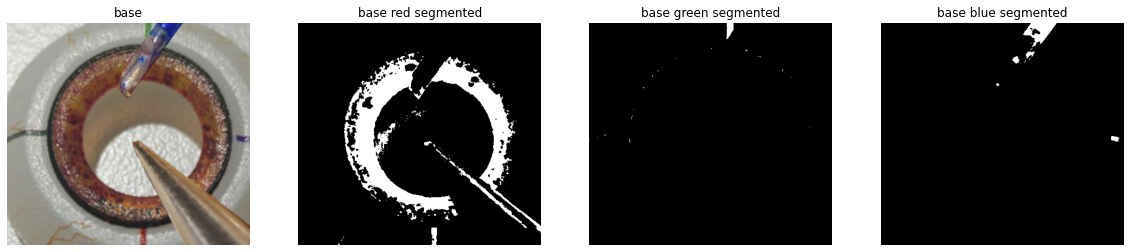

In [9]:
fig, (plot1, plot2, plot3, plot4) = plt.subplots(1, 4, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base red segmented')
plot2.imshow(segment_color(base_hsv, 'red'), cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('base green segmented')
plot3.imshow(segment_color(base_hsv, 'green'), cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('base blue segmented')
plot4.imshow(segment_color(base_hsv, 'blue'), cmap=plt.cm.gray)
plot4.axis('off')

plt.show()

### Hough transform on lines

In [10]:
lines = cv2.HoughLines(cv2.Canny(base_green, 0, 255), 1, np.pi / 180, 1)

base_test = base_rgb.copy()
for line in lines:
    line = line[0]
    rho = line[0]
    theta = line[1]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
    pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
    cv2.line(base_test, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
    break
    
fig, plot = plt.subplots(1, 1, figsize=(20,10))
plot.imshow(base_test)

plt.show()

NameError: name 'base_green' is not defined

### Polar warp approach

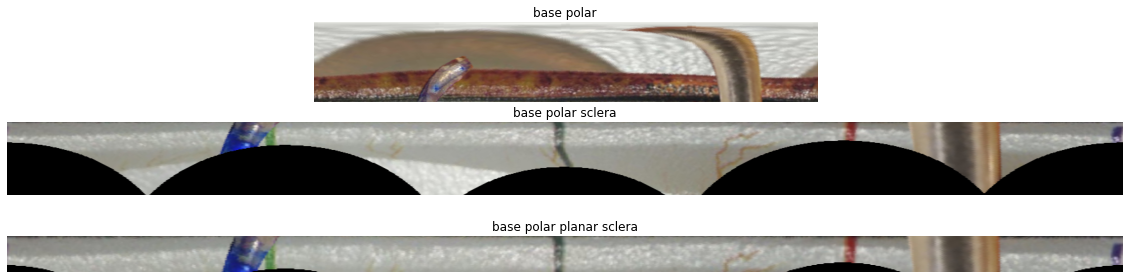

In [11]:
fig, (plot1, plot2, plot3) = plt.subplots(3, 1, figsize=(20,5))
plot1.set_title('base polar')
plot1.imshow(linear_polar_warp(base_rgb, center, radius))
plot1.axis('off')

plot2.set_title('base polar sclera')
plot2.imshow(linear_polar_warp(base_rgb, center, radius*SCLERA_TO_LIMBUS_RATIO, radius))
plot2.axis('off')

plot3.set_title('base polar planar sclera')
plot3.imshow(linear_polar_warp(base_rgb, center, radius*PLANAR_SCLERA_TO_LIMBUS_RATIO, radius))
plot3.axis('off')

plt.show()

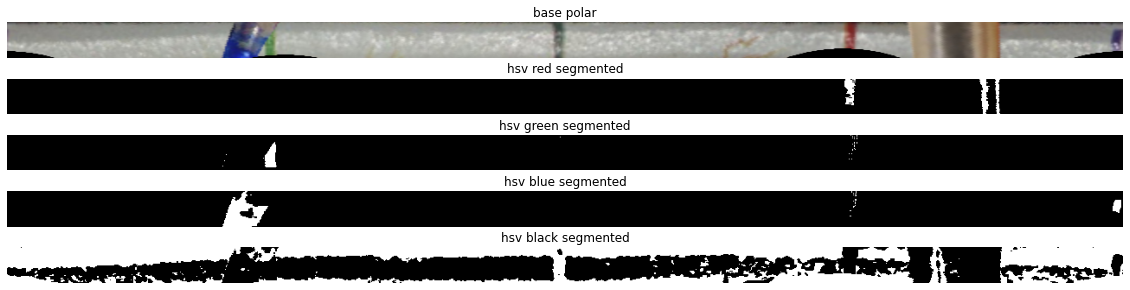

In [12]:
base_hsv_polar = linear_polar_warp(base_hsv, center, radius*PLANAR_SCLERA_TO_LIMBUS_RATIO, radius)
red_polar = segment_color(base_hsv_polar, 'red')
green_polar = segment_color(base_hsv_polar, 'green')
blue_polar = segment_color(base_hsv_polar, 'blue')
black_polar = segment_color(base_hsv_polar, 'black')

fig, (plot1, plot2, plot3, plot4, plot5) = plt.subplots(5, 1, figsize=(20,5))
plot1.set_title('base polar')
plot1.imshow(linear_polar_warp(base_rgb, center, radius*PLANAR_SCLERA_TO_LIMBUS_RATIO, radius))
plot1.axis('off')

plot2.set_title('hsv red segmented')
plot2.imshow(red_polar, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hsv green segmented')
plot3.imshow(green_polar, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('hsv blue segmented')
plot4.imshow(blue_polar, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('hsv black segmented')
plot5.imshow(black_polar, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

### Stacking color strips

In [13]:
def stack_vertical(strips, split=0.24):
    width = strips[0].shape[1]
    height = strips[0].shape[0]
    result = np.zeros((height*len(strips),width))
    for i, strip in enumerate(strips):
        split_th = round((i*split % 1.0) * width)
        result[i*height:(i+1)*height,width-split_th:] = strip[:,0:split_th]
        result[i*height:(i+1)*height,:width-split_th] = strip[:,split_th:]
    
    return result

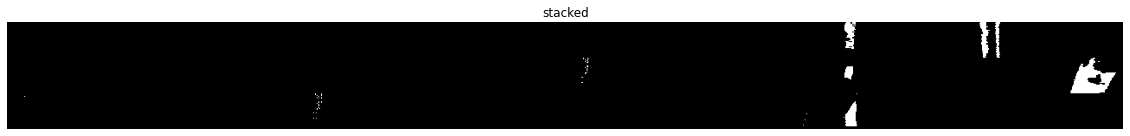

In [14]:
stacked = stack_vertical((red_polar, blue_polar, green_polar))

fig, plot1 = plt.subplots(1, 1, figsize=(20,5))
plot1.set_title('stacked')
plot1.imshow(stacked, cmap='gray')
plot1.axis('off')

plt.show()

### Summing vertically
- Can fail when there are instruments involved

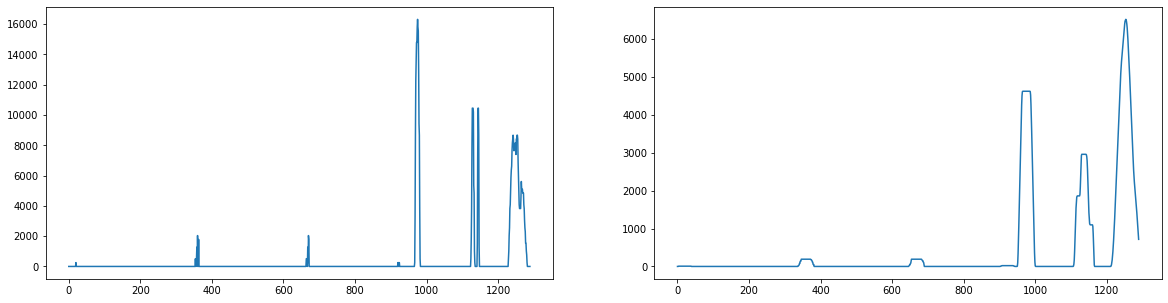

max: 6523.75, argmax: 1253


In [15]:
vertical_sum = np.sum(stacked, axis=0)
box_kernel_width = round(vertical_sum.size/36)
box_kernel = np.ones(box_kernel_width)/box_kernel_width
vertical_sum_smooth = np.convolve(vertical_sum, box_kernel, mode='same')

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20,5))
plot1.plot(vertical_sum)
plot2.plot(vertical_sum_smooth)

plt.show()

print('max: %s, argmax: %s' % (
    np.max(vertical_sum_smooth),
    np.argmax(vertical_sum_smooth)
))

### Hu moments for calculating vertical variance

In [16]:
# window_width = round(20*stacked.shape[1]/360)
window_width = 16
moments = []
for i in range(360):
    window_center = round(i*stacked.shape[1]/360)
    window = stacked[
        :,
        max(0, window_center-window_width//2):min(stacked.shape[1],window_center+window_width//2)
    ]
    moments.append(cv2.moments(window, binaryImage=True))

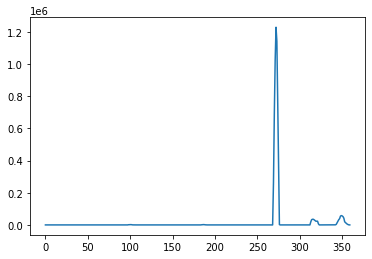

In [17]:
moment_vis = 'mu02'
a = np.array([m[moment_vis] for m in moments])

plt.plot(a)

In [18]:
moments[160]

{'m00': 0.0,
 'm10': 0.0,
 'm01': 0.0,
 'm20': 0.0,
 'm11': 0.0,
 'm02': 0.0,
 'm30': 0.0,
 'm21': 0.0,
 'm12': 0.0,
 'm03': 0.0,
 'mu20': 0.0,
 'mu11': 0.0,
 'mu02': 0.0,
 'mu30': 0.0,
 'mu21': 0.0,
 'mu12': 0.0,
 'mu03': 0.0,
 'nu20': 0.0,
 'nu11': 0.0,
 'nu02': 0.0,
 'nu30': 0.0,
 'nu21': 0.0,
 'nu12': 0.0,
 'nu03': 0.0}

### Custom measure

In [22]:
window_width = round(20*stacked.shape[1]/360)
measure = []
for i in range(360):
    window_center = round(i*stacked.shape[1]/360)
    window = stacked[
        :,
        max(0, window_center-window_width//2):min(stacked.shape[1],window_center+window_width//2)
    ]
    
    measure.append(np.sum(window, axis=1))
    
measure = np.array(measure)

In [23]:
entropy = []
for i in range(measure.shape[0]):
    values = measure[i,:]
    values = values[values != 0]
    if values.shape[0] == 0:
        entropy.append(0)
        continue
    
    values = values / np.sum(values)
    entropy.append(np.sum(np.multiply(-values, np.log(values))))

entropy = np.array(entropy)

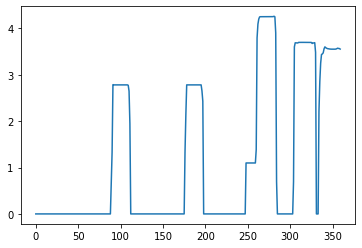

In [24]:
plt.plot(entropy)

In [36]:
entropy_eps = np.log(0.8)

max_entropy = np.max(entropy)
optimal_deg = np.where(entropy > (max_entropy + entropy_eps))
np.median(optimal_deg)

272.0

### Additional tests

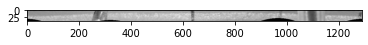

In [58]:
test = linear_polar_warp(base_hsv[:,:,2], center, radius*PLANAR_SCLERA_TO_LIMBUS_RATIO, radius)
# test[test == 0] = 255
plt.imshow(test, cmap='gray')

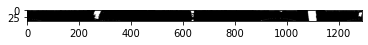

In [59]:
_, th = cv2.threshold(test, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)
th[test == 0] = 0
plt.imshow(th, cmap='gray')

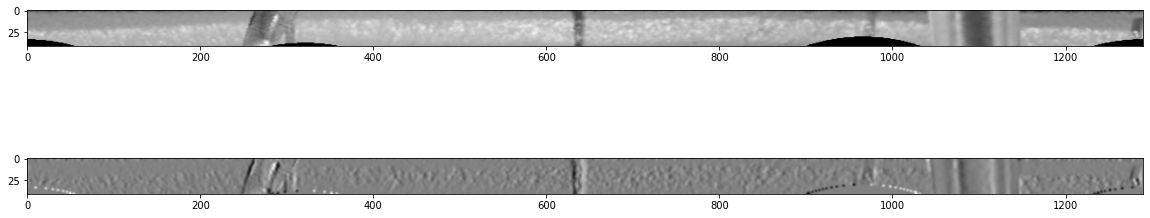

In [63]:
test = linear_polar_warp(base_hsv[:,:,2], center, radius*PLANAR_SCLERA_TO_LIMBUS_RATIO, radius)
sobelx = cv2.Sobel(test, cv2.CV_64F, 1, 0, ksize=5)

fig, (plot1, plot2) = plt.subplots(2, 1, figsize=(20,5))
plot1.imshow(test, cmap='gray')
plot2.imshow(sobelx, cmap='gray')

plt.show()

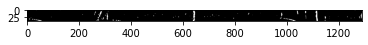

In [71]:
v = np.sort(np.abs(sobelx.ravel()))
th = v[round(v.size * 0.95)]

mask = np.zeros(test.shape)
mask[sobelx > th] = 255
plt.imshow(mask, cmap='gray')

### Generating images

In [35]:
cv2.imwrite('technical_base.png', base)
cv2.imwrite('technical_limbus_mask.png', limbus_mask)
cv2.imwrite('technical_base_polar.png', linear_polar_warp(base, center, radius*PLANAR_SCLERA_TO_LIMBUS_RATIO, radius))
cv2.imwrite('technical_red_polar.png', red_polar)
cv2.imwrite('technical_blue_polar.png', blue_polar)
cv2.imwrite('technical_green_polar.png', green_polar)
cv2.imwrite('technical_stacked_polar.png', stacked)

True